In [0]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cd "drive/My Drive/Colab Notebooks/"

/content/drive/My Drive/Colab Notebooks


In [3]:
if torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print(device)

cuda


In [0]:
data = np.load("mnist_train_images.npy")
data.shape
data = torch.Tensor(data - 127.5)/127.5

In [0]:
class Generator(torch.nn.Module):
  
  def __init__(self):
    super(Generator, self).__init__()
    
    self.fc1 = torch.nn.Linear(in_features=100,out_features=7*7*256,bias=False)
    self.bn1 = torch.nn.BatchNorm1d(num_features=7*7*256)
    self.lrelu = torch.nn.LeakyReLU(0.3)
    self.tc1 = torch.nn.ConvTranspose2d(in_channels=256,out_channels=128,kernel_size=5,stride=1,padding=2,bias=False)
    self.bn2 = torch.nn.BatchNorm2d(128)
    self.tc2 = torch.nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=4,stride=2,padding=1,bias=False)
    self.bn3 = torch.nn.BatchNorm2d(64)
    self.tc3 = torch.nn.ConvTranspose2d(in_channels=64,out_channels=1,kernel_size=4,stride=2,padding=1,bias=False)
    self.tan = torch.nn.Tanh()

  def forward(self, x, batch_size):

    out = self.fc1(x)
    out = self.bn1(out)
    out = self.lrelu(out)
    out = torch.reshape(out, (batch_size,256,7,7))
    out = self.tc1(out)
    out = self.bn2(out)
    out = self.lrelu(out)
    out = self.tc2(out)
    out = self.bn3(out)
    out = self.lrelu(out)
    out = self.tc3(out)
    out = self.tan(out)

    return out

In [0]:
class Discriminator(torch.nn.Module):

  def __init__(self):
    super(Discriminator, self).__init__()
    
    self.c1 = torch.nn.Conv2d(in_channels=1,out_channels=64,kernel_size=4,stride=2,padding=15)
    self.lrelu = torch.nn.LeakyReLU(0.3)
    self.drp = torch.nn.Dropout(0.3)
    self.c2 = torch.nn.Conv2d(in_channels=64,out_channels=128,kernel_size=4,stride=2,padding=15)
    self.dn = torch.nn.Linear(28*28*128,1)
    self.sig = torch.nn.Sigmoid()


  def forward(self, x, batch_size):
    
    out = self.c1(x)
    out = self.lrelu(out)
    out = self.drp(out)
    out = self.c2(out)
    out = self.lrelu(out)
    out = self.drp(out)
    out = out.view(batch_size,28*28*128)
    out = self.dn(out)
    out = self.sig(out)

    return out

In [0]:
def gen_train(gen, disc, real_labels, batch_size=1, z_size=100):

  z = torch.randn(batch_size, z_size).to(device)
  gen_out = gen(z, batch_size)
  disc_out = disc(gen_out, batch_size)

  gen_optim.zero_grad()
  loss = torch.nn.BCELoss()
  error = loss(disc_out, real_labels)
  error.backward()
  gen_optim.step()

  return error

In [0]:
def disc_train(gen, disc, real_data, real_labels, fake_labels, batch_size=1, z_size=100):
  
  z = torch.randn(batch_size, z_size).to(device)
  gen_out = gen(z, batch_size)
  real_pred = disc(real_data, batch_size)
  fake_pred = disc(gen_out, batch_size)

  disc_optim.zero_grad()
  loss = torch.nn.BCELoss()
  error = loss(real_pred, real_labels) + loss(fake_pred, fake_labels)
  error.backward()
  disc_optim.step()

  real_val = torch.mean(real_pred)
  fake_val = torch.mean(fake_pred)

  return error, real_val, fake_val

In [0]:
def train_gan(gen, disc, data, batch_size=1, z_size=100, k=1, epochs=10):

  real_labels = torch.ones(batch_size,1).to(device)
  fake_labels = torch.zeros(batch_size, 1).to(device)
  
  for epoch in range(epochs):
    for i in range(0, len(data), batch_size):
      real_data = data[i:i+batch_size].to(device)
      real_data = real_data.view(batch_size,1,28,28)

      for i in range(k):
        disc_loss, real_val, fake_val = disc_train(gen, disc, real_data, real_labels, fake_labels, batch_size, z_size)

      gen_loss = gen_train(gen, disc, real_labels, batch_size, z_size)

    if(epoch+1)%10 == 0 or epoch == 0:
      print("Epoch: ", epoch+1)
      print("Discriminator Loss: ", disc_loss.item())
      print("Real Mean: ", real_val.item())
      print("Fake Mean: ", fake_val.item())
      print("Generator Loss: ", gen_loss.item())

In [0]:
gen = Generator().to(device)
disc = Discriminator().to(device)
gen_optim = torch.optim.Adam(gen.parameters(), lr=0.0002)
disc_optim = torch.optim.Adam(disc.parameters(), lr=0.0003)

In [11]:
train_gan(gen, disc, data, batch_size=1000, k=1, epochs=100)

Epoch:  1
Discriminator Loss:  0.3214377760887146
Real Mean:  0.9065479040145874
Fake Mean:  0.0503450408577919
Generator Loss:  7.201324462890625
Epoch:  10
Discriminator Loss:  0.6990410089492798
Real Mean:  0.782065212726593
Fake Mean:  0.16772855818271637
Generator Loss:  3.187502861022949
Epoch:  20
Discriminator Loss:  1.0155141353607178
Real Mean:  0.7120890021324158
Fake Mean:  0.24676133692264557
Generator Loss:  3.129859447479248
Epoch:  30
Discriminator Loss:  0.8224051594734192
Real Mean:  0.7221975326538086
Fake Mean:  0.16102924942970276
Generator Loss:  2.745131731033325
Epoch:  40
Discriminator Loss:  0.9896649122238159
Real Mean:  0.7103350162506104
Fake Mean:  0.29493585228919983
Generator Loss:  2.162018060684204
Epoch:  50
Discriminator Loss:  0.7293925881385803
Real Mean:  0.802000105381012
Fake Mean:  0.24977946281433105
Generator Loss:  2.1998071670532227
Epoch:  60
Discriminator Loss:  1.1731317043304443
Real Mean:  0.6033712029457092
Fake Mean:  0.2626130282878

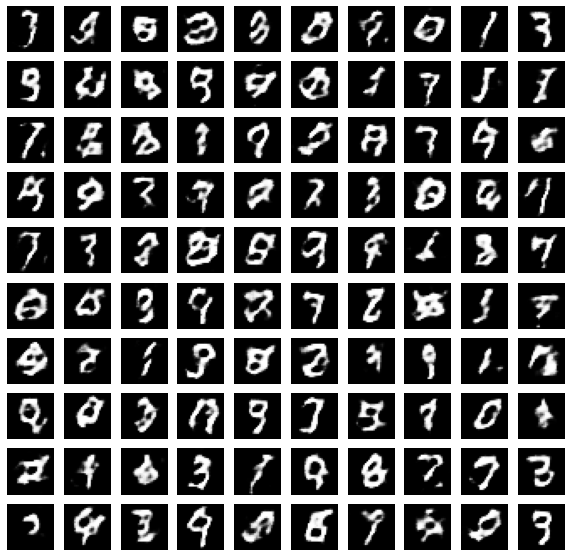

In [12]:
fig, ax = plt.subplots(figsize=(10,10), nrows=10, ncols=10)

plt.axis('off')
for row in ax:
  dummy = torch.randn(10,100).to(device)
  image = gen(dummy, 10)
  j = 0
  for col in row:
    img = image[j]
    img = img.view(28,28)
    col.imshow(img.detach().cpu().numpy(), cmap="gray")
    col.set_axis_off()
    j += 1
    
plt.show()